In [4]:
import numpy as np
from skimage.measure import label
import scipy.io as io
import pandas
import os

keys = ['D1','D2','D3']
folders = ['dataset1','dataset2','dataset3']
sampfreq = [1000,1000,500]
df = pandas.DataFrame(columns=['source','set','duration','amplitude','peak_velocity'])
for i,f in enumerate(folders):
    datapath = os.path.join('../data',f)
    print(datapath)
    # load training data
    Xtrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[i])+'hz_X_train.csv',delimiter=',')
    Ytrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[i])+'hz_Y_train.csv',delimiter=',')
    Ltrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[i])+'hz_Labels_train.csv',delimiter=',')
    
    Ltrain = (Ltrain==1).astype(float) #get saccade class only
    
    # differentiate
    Xtraindiff = np.diff(Xtrain,1); Ytraindiff = np.diff(Ytrain,1); 
    #Ltraindiff = np.diff(Ltrain,1); # <- this is useless 
    
    Ztrain = np.sqrt(Xtraindiff**2+Ytraindiff**2)*1000*1000/sampfreq[i]
    
    for row in range(Ltrain.shape[0]):
        
        Labeltrain = label(Ltrain[row,:])
        
        for n in range(1,np.max(Labeltrain)+1):
            saccinds = np.argwhere(Labeltrain==n)
            if ((saccinds[0]==0) or (saccinds[-1]==len(Labeltrain)-1)): # skip saccades on the edges of the trace
                continue
            else:
                count = np.sum(Labeltrain==n)*1000/sampfreq[i]
                amp = np.sqrt((Xtrain[row,saccinds[-1]]-Xtrain[row,saccinds[0]])**2 + (Ytrain[row,saccinds[-1]]-Ytrain[row,saccinds[0]])**2)[0]
                peak_vel = np.max(Ztrain[row,Labeltrain[1:]==n])
                df = df.append({'source':keys[i],
                               'set':'train',
                               'duration':count,
                               'amplitude':amp,
                               'peak_velocity':peak_vel},ignore_index=True)

../data/dataset1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


../data/dataset2
../data/dataset3


In [5]:
df.to_pickle('sacc_stats.pkl')

In [6]:
import numpy as np
from skimage.measure import label
import scipy.io as io
import pandas
keys = ['D1','D2','D3']
df = pandas.read_pickle('sacc_stats.pkl')
df[np.isinf(df['amplitude'])] = np.nan

In [7]:
df2 = pandas.DataFrame(columns=['dataset','d_mean','d_median','d_min','d_max','d_std',
                                'a_mean','a_median','a_min','a_max','a_std',
                                'v_mean','v_median','v_min','v_max','v_std'])
for k in keys:
    if ((k=='F') or (k=='A')):
        factor = 2
    else:
        factor = 1
    df2 = df2.append({
        
        'dataset':k,
        'd_mean':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].mean(),2),
        'd_median':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].median(),2),
        'd_min':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].min(),4),
        'd_max':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].max(),4),
        'd_std':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].std(),2),

        'a_mean':np.round(df[df['source']==k]['amplitude'].mean(),2),
        'a_median':np.round(df[df['source']==k]['amplitude'].median(),2),
        'a_min':np.round(df[((df['source']==k)&(df['duration']>1))]['amplitude'].min(),4),
        'a_max':np.round(df[((df['source']==k)&(df['duration']>1))]['amplitude'].max(),4),
        'a_std':np.round(df[((df['source']==k)&(df['duration']>1))]['amplitude'].std(),2),
        
        'v_mean':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].mean(),2)/factor,
        'v_median':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].median(),2)/factor,
        'v_min':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].min(),4)/factor,
        'v_max':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].max(),4)/factor,
        'v_std':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].std(),2)/factor,

    },ignore_index=True)

In [8]:
from IPython.display import display
display(df2)


,dataset,d_mean,d_median,d_min,d_max,d_std,a_mean,a_median,a_min,a_max,a_std,v_mean,v_median,v_min,v_max,v_std
0,D1,44.58,42.0,11.0,169.0,15.42,0.69,0.43,0.0202,11.3368,0.93,102.46,81.91,17.8113,547.7185,68.82
1,D2,37.51,36.0,18.0,97.0,8.81,1.07,0.96,0.0356,7.0265,0.70,68.23,56.59,11.4947,450.4380,42.98
2,D3,23.12,22.0,8.0,54.0,6.52,0.07,0.06,0.0029,0.3809,0.04,62.40,59.57,25.5036,167.7679,19.75


# Example Traces

In [9]:
cols = [[0,0.5,0.7],[0.1,0.7,0.8],[0.9,0.4,0.0],[0.2,0.8,0.6]]

In [10]:
import ueye
from skimage.measure import label
from matplotlib.pyplot import *
import torch
from torch.autograd import Variable
from scipy.signal import resample
import scipy.io as io
from matplotlib import gridspec
net = ueye.functions.UNet()

dataset1
dataset2
dataset3
Synthetic


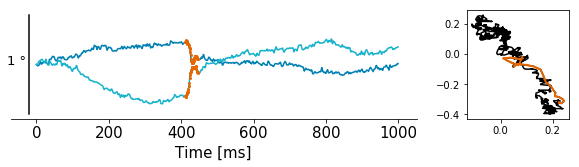

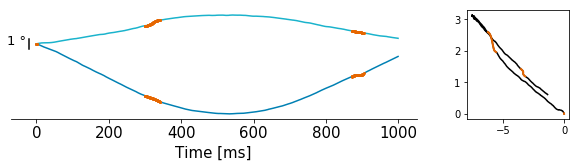

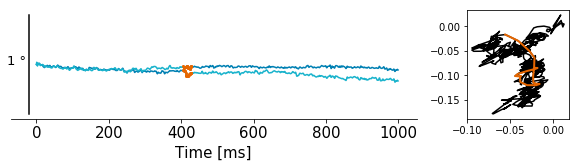

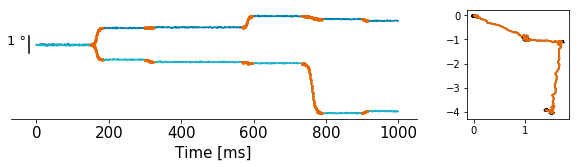

In [26]:
folders = ['dataset1','dataset2','dataset3','Synthetic']
deg = [0.2,1,1,0.02,1,1]
inds = [80,49,31,6,
        52]
for j,f in enumerate(folders):
    print(f)
    datapath = '../data/' + f
    if f=='Synthetic':
        Xtrain = np.loadtxt(datapath+'/X_1000hz.csv',delimiter=',')
        Ytrain = np.loadtxt(datapath+'/Y_1000hz.csv',delimiter=',')
        Ltrain = np.loadtxt(datapath+'/Labels_1000hz.csv',delimiter=',')
    else:
        Xtrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[j])+'hz_X_train.csv',delimiter=',')
        Ytrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[j])+'hz_Y_train.csv',delimiter=',')
        Ltrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[j])+'hz_Labels_train.csv',delimiter=',')

    t = np.arange(1000)
    i = inds[j]
    if (f=='dataset3'):
        n_time = Xtrain.shape[1]
        Xtrain = resample(Xtrain.copy(),n_time*int(1000/500),axis=1)[:,:1000]
        Ytrain = resample(Ytrain.copy(),n_time*int(1000/500),axis=1)[:,:1000]
        Ltrain = resample(Ltrain.copy(),n_time*int(1000/500),axis=1)[:,:1000]
        Ltrain[Ltrain<0.5] = 0
        Ltrain[Ltrain>=0.5] = 1
    l = Ltrain[i,:].astype(float).copy()
    
    f1 = figure(figsize=(10,2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
    x = Xtrain[i,:].copy()
    y = Ytrain[i,:].copy()
    x = x-x[0]
    y = y-y[0]
    
    ax = subplot(gs[0])
    plot(t,x,c=cols[0],label='horizontal') 
    plot(t,y,c=cols[1],label='vertical') 
    x[l==0] = np.nan
    y[l==0] = np.nan
    plot(t,x,c=cols[2],marker='.',markersize=4,linewidth=0,label='saccade') 
    plot(t,y,c=cols[2],marker='.',markersize=4,linewidth=0,) 
    plot([-20,-20],[-0.5,0.5],'k')
    text(-80,0,str(1)+' °',fontsize=13)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    yticks(())
    xticks(fontsize=15)
    xlabel('Time [ms]',fontsize=15)
    
    x = Xtrain[i,:].copy()
    y = Ytrain[i,:].copy()
    x = x-x[0]
    y = y-y[0]
    ax = subplot(gs[1])
    plot(x,y,c='k',label='fixation')
    x[l==0] = np.nan
    y[l==0] = np.nan
    plot(x,y,c=cols[2],markersize=4,linewidth=2,label='saccade') 
    savefig('../summary/examples_'+f+'.pdf',bbox_inches='tight')